# Monte Carlo methods
Auhtor: Artur Kalinowski

Direck [link](https://akalinow.github.io/Modern_Particle_Physics_Experiments/slides/monte_carlo_01.pdf) to the slides.

In [1]:
from IPython.display import IFrame
#This might not work in colab. In such a case follow the link to the slides above. 
IFrame("https://akalinow.github.io/Modern_Particle_Physics_Experiments/slides/monte_carlo_01.pdf", width=1000, height=700)

## Setup the environment

In [2]:
#import ROOT

#Color printing
from termcolor import colored

#General data operations library
import math
import numpy as np

#HEP specific tools
import scipy.constants as scipy_constants

#Plotting libraries
import matplotlib.pyplot as plt

#Increase plots font size
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (10, 7),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

### Probability distribution (PDF) and cumulative distribution (CDF) functions

Consider random numbers from range [0,1] distributed according to the triangle distribution:

\begin{equation}
 p(x) = 2x
\end{equation}

* plot the probability density function (PDF)
* plot the cumulative probability function (CDF)
* plot inverse of the CDF: $F^{-1}(p)$

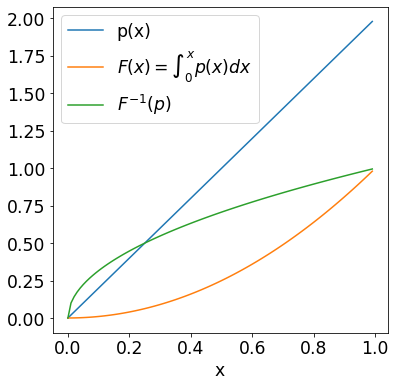

In [3]:
def pdf(x):
    p = np.where(np.logical_and(x>0, x<1), 2*x, 0)
    return p

def cdf(x):
    cdf = np.where(np.logical_and(x>0, x<1), x**2,0)
    return cdf

def invCDF(x):
    value = np.where(np.logical_and(x>0, x<1),np.sqrt(x),0)
    return value
    
fig, ax = plt.subplots(figsize=(6, 6))

x = np.arange(0,1.0,0.01)
ax.plot(x,pdf(x), label="p(x)");
ax.plot(x,cdf(x), label=r"$F(x) = \int_{0}^{x}p(x)dx$");
ax.plot(x,invCDF(x), label=r"$F^{-1}(p)$");
ax.set_xlabel("x")
ax.set_ylabel("")
ax.legend();

### Random number generation using inverse of CDF

* generate 100k numbers from triangle distribution using the inverse of the CDF
* plot a histogram of numbers with PDF overaild 

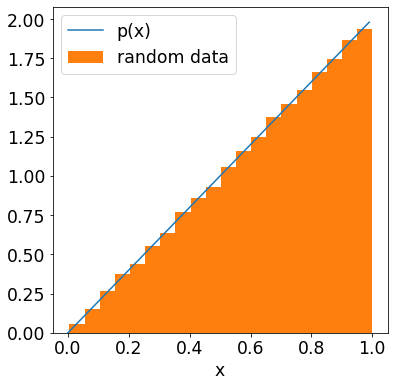

In [4]:
def drawNumbers(nPoints, invCDF):
    x = np.random.random(nPoints)
    x = invCDF(x)
    return x

fig, ax = plt.subplots(figsize=(6, 6))

x = np.arange(0,1,0.01)
nPoints = 100000
sample = drawNumbers(nPoints, invCDF)

ax.plot(x,pdf(x), label="p(x)");
ax.hist(sample, bins=20, density=True, label="random data");
ax.set_xlabel("x")
ax.set_ylabel("")
ax.legend();

### Python modules with physical constants

Print out the values and uncerainties of:

* the Fermi constant
* muon mass
* electron mass
* define variables ```G_F```, ```m_e``` and ```m_mu``` containg only the values of relevant contants

In [5]:
G_F = scipy_constants.physical_constants["Fermi coupling constant"]
m_e = scipy_constants.physical_constants["electron mass energy equivalent in MeV"]
m_mu = scipy_constants.physical_constants["muon mass energy equivalent in MeV"]

print("Fermi constant: {} +- {} {}".format(G_F[0], G_F[2], G_F[1]))
print("muon mass: \t{} +- {} {}".format(m_mu[0], m_mu[2], m_mu[1]))
print("electron mass: \t{} +- {} {}".format(m_e[0], m_e[2], m_e[1]))

G_F = G_F[0]
m_e = m_e[0]
m_mu = m_mu[0]

Fermi constant: 1.1663787e-05 +- 6e-12 GeV^-2
muon mass: 	105.6583755 +- 2.3e-06 MeV
electron mass: 	0.51099895 +- 1.5e-10 MeV


* write a function coding the differential decay width: ```dGamma_dE(E)```
* calculate the value of the total decay width: ```Gamma_tot```
* calculate and print out the muon life time in seconds: ```tau_mu```

In [6]:
def dGamma_dE(e):
    value = G_F**2/(4.0*math.pi**3)
    value *= m_mu**2*e**2*(1 - 4.0/3.0*e/m_mu)
    return value

Gamma_tot = G_F**2*m_mu**5/(192.0*math.pi**3)

hbar = scipy_constants.physical_constants["Planck constant in eV/Hz"][0]/(2*math.pi)
tau_mu = hbar/Gamma_tot

print("Muon life time is {:3.3e} seconds".format(tau_mu))

Muon life time is 2.187e-12 seconds



* calculate (on piece of paper) the maximum electron energy in muon decay (neglecting the neutrinos mass) and assing in to variable ```e_max```
* print out the ```e_max```

In [7]:
e_max = (m_mu**2 - m_e**2)/(2.0*m_mu)
print("Maximum electron energy in muon decay (neglecting neutrinos mass): {} MeV".format(e_max))

Maximum electron energy in muon decay (neglecting neutrinos mass): 52.827952069791664 MeV


### Plot the probability for the electron energy

* check that the normalisation is correct - calculate numerically
\begin{equation}
\int p(E) dE
\end{equation}


Integral of p(E) is: 0.99995


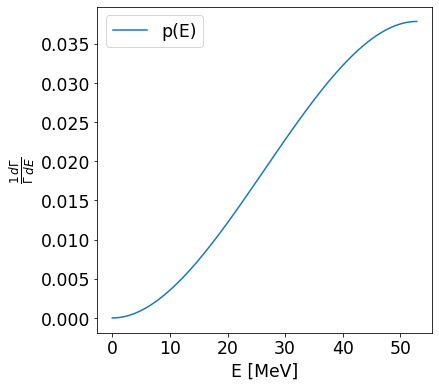

In [8]:
nPoints = 100
e = np.linspace(0.0, e_max, nPoints)
p = dGamma_dE(e)/Gamma_tot

print("Integral of p(E) is: {:1.5f}".format(np.sum(p)*e_max/nPoints))

fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(e,p, label="p(E)");
ax.set_xlabel("E [MeV]")
ax.set_ylabel(r"$\frac{1}{\Gamma} \frac{d\Gamma}{dE}$")
ax.legend();

### Event generation

Generate "events" with energy distribution according to $\mu \rightarrow e \nu$ decay

* use "hit-or-miss method":
    1) generate energy ```e``` from flat spectrum [0, $E_{max}$]
    2) generate random number ```x``` from flat spectrum [0,1]
    3) accept event if ```x<p(e)```
    4) what is efficiency (=what fraction of events is kept) of this method?
    5) How long it takes to generate 100k usefull events?
 
--- 
**Hint:**  try to use numpy array operations instead of loops. This will be much faster.  

In [9]:
%%time

nEvents = int(2E6)
events = e_max*np.random.random_sample(nEvents)
x = np.random.random_sample(nEvents)
p = dGamma_dE(events)
p = p/np.max(p)
accept = x<p

events = events[accept]
print("Number of accepted events:\t",events.shape[0])
print("Accepted events fraction:\t",events.shape[0]/nEvents)

Number of accepted events:	 1000322
Accepted events fraction:	 0.500161
CPU times: user 69.1 ms, sys: 4.07 ms, total: 73.2 ms
Wall time: 72.1 ms


* draw a histogram of the energy with p(E) overlaid

Integral of p(E) is: 0.9999532221306278


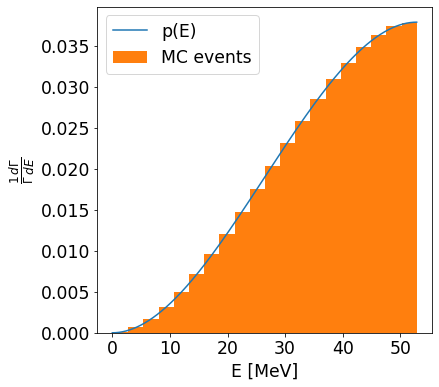

In [10]:
nPoints = 10000
e = np.linspace(0.0, e_max, nPoints)
p = dGamma_dE(e)/Gamma_tot

print("Integral of p(E) is:",np.sum(p)*e_max/nPoints)

fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(e,p, label="p(E)");
ax.hist(events,bins=20, density=True, label = "MC events")
ax.set_xlabel("E [MeV]")
ax.set_ylabel(r"$\frac{1}{\Gamma} \frac{d\Gamma}{dE}$")
ax.legend();

### PASS/FAIL values generation

Define a function ```efficiency(pt, eta)``` representing some detector efficiency. 
The efficiency plateau $\epsilon_0$, and turn on $p_{T0}$ point should depend on $\eta$:

\begin{equation}
\epsilon_{0} = 0.95 - |\eta| \cdot 0.1 \\
 p_{T0} = 30 + 20 \cdot cos(\eta)
\end{equation}

Use the sigmoid function for the efficiency shape. The $p_{T}$ should be in range [0,100], and $\eta$ in [-2.5, 2.5].

In [11]:
def efficiency(pt, eta):
    pt0 = 30+20*np.cos(eta)
    x = pt-pt0
    epsilon0 = 0.95 - np.abs(eta)*0.1
    return epsilon0/(1 + np.exp(-x))

* make a 1D plot for $\epsilon(p_{T}, \eta={-2, 0, 1})$
* make a 2D plot for the full map $\epsilon(p_{T}, \eta)$

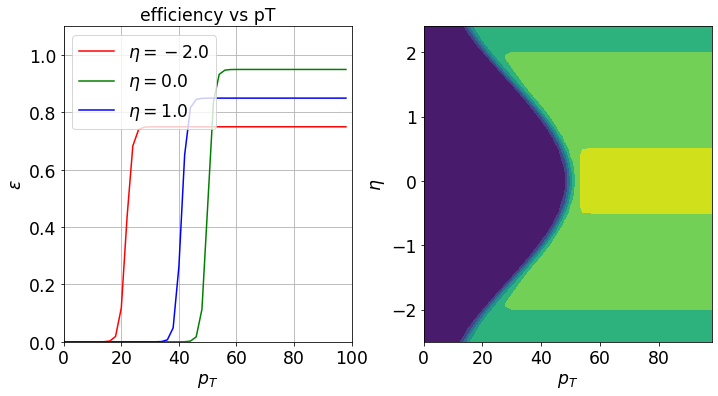

In [12]:
pt = np.arange(0,100,2.0)
eta = np.arange(-2.5, 2.5, 0.1)
pt_grid, eta_grid = np.meshgrid(pt, eta)

fig, axes = plt.subplots(1, 2, figsize = (10, 6))  
axes[0].plot(pt, efficiency(pt, -2.0), "r", label = r'$\eta = -2.0$')
axes[0].plot(pt, efficiency(pt, 0.0), "g",label = r'$\eta = 0.0$')
axes[0].plot(pt, efficiency(pt, 1.0), "b",label = r'$\eta = 1.0$')

maxY = 1.1
maxX = 100
axes[0].set_ylabel(r'$\epsilon$');
axes[0].set_xlabel(r'$p_{T}$');
axes[0].grid()
axes[0].set_ylim([0,maxY])
axes[0].set_xlim([0,maxX])
axes[0].set_title("efficiency vs pT")
axes[0].legend(loc='upper left')

axes[1].contourf(pt_grid, eta_grid, efficiency(pt_grid, eta_grid))
axes[1].set_ylabel(r'$\eta$');
axes[1].set_xlabel(r'$p_{T}$');

plt.subplots_adjust(bottom=0.15, left=0.05, right=0.95, wspace=0.25, hspace=0.35)

Write a function ```generateData(nPoints, efficiency)``` that generates a sample of ```nPoints``` events, with information wheter an event was accepted, according to function ```effciency(pT, eta)``` that parametrises $\epsilon$ 

* assume flat $p_{T}$ and $\eta$ spectrum. The pT should be in range [0,100], an $\eta$ in [-2.5, 2.5].
* to each $(p_{T}, \eta)$ pair assing a third variable: ```label``` randomly set to 0 or 1 according to the  ```efficiency(pt, eta)```

In [13]:
def generateData(nPoints, efficiency):
    scale = [100, 2*2.1]
    offset = [0, -2.1]

    features = np.random.random_sample(size=(nPoints,2))
    features = features*scale + offset
        
    flatRndm = np.random.random_sample(size=(nPoints,))
    labels = flatRndm<efficiency(features[:,0], features[:,1])
    labels = np.reshape(labels, (-1,1))
    return np.concatenate((features,labels), axis=1)

* generate 100k events
* select data rows with $|\eta|<0.1$
* further select accepted events with ```pass>0```
* calculate efficiency a ratio of accepted to total events in bint of $p_{T}$. Use 10 bins. 

**Hints:** 
* for counting numbeszs of events in bins use ```np.hist```
* for getting the bin centers use ```np.diff```

In [14]:
%%time
nPoints = 100000
binWidth = 1.0
data = generateData(nPoints, efficiency)
data_eta01 = data[np.abs(data[:,1])<0.1]
data_pass = data_eta01[data_eta01[:,2]>0]

pass_histo, bins = np.histogram(data_pass[:,0], bins=np.arange(0,100,binWidth))
all_histo, bins =  np.histogram(data_eta01[:,0], bins=np.arange(0,100,binWidth))
ratio = np.divide(pass_histo, all_histo.astype(float))
binCenters = bins[:-1] + np.diff(bins)

CPU times: user 10.5 ms, sys: 109 µs, total: 10.6 ms
Wall time: 10.1 ms


* plot efficiency from function for $\eta=0$
* overlay efficiency from event counting from data
* do the two agree? If not exactly, then why?

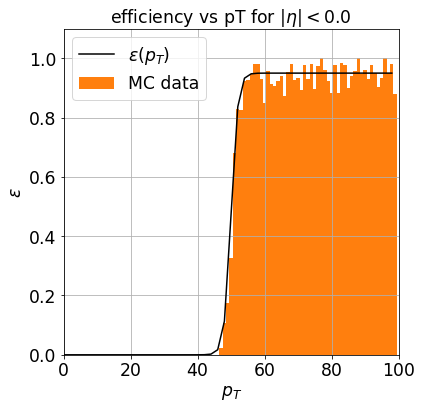

In [15]:
pt = np.arange(0,100,2.0)
eta = np.arange(-2.5, 2.5, 0.1)
pt_grid, eta_grid = np.meshgrid(pt, eta)

fig, ax = plt.subplots(figsize = (6, 6))  
ax.plot(pt, efficiency(pt, 0.0), color="black",label = r"$\epsilon(p_{T})$")
ax.bar(binCenters, ratio, width=binWidth, color="#ff7f0e", label = 'MC data')

maxY = 1.1
maxX = 100
ax.set_ylabel(r'$\epsilon$');
ax.set_xlabel(r'$p_{T}$');
ax.grid()
ax.set_ylim([0,maxY])
ax.set_xlim([0,maxX])
ax.set_title(r"efficiency vs pT for |$\eta|<0.0$")
ax.legend(loc='upper left');

## Energy smearing.

Write a function ```smearEnergy(e, sigma)``` that smears a "true" energy according to desired relative resolution $\sigma$:

\begin{equation}
   x = \frac{\Delta{E}}{E_{true}} + 1 = \frac{E_{reco}}{E_{true}}\\
   p(x) = \frac{1}{\sigma \sqrt{2\pi}}e^{-\frac{(x-1)^{2}}{2\sigma^{2}}}
\end{equation}


* create a sample of 10k "events" with energy equal to ```e=10```
* create a sample with energy smeared from according to ```smearEnergy(e, sigma)``` with relative resolution of 20%
* plot histograms of both datasets
* calculate the standard deviation of the relative energy difference

In [16]:
def smearEnergy(data, sigma):
    smearFactor = 1 + sigma*np.random.randn(data.shape[0])
    return data*smearFactor


data = np.array([1,1,1])
smeared_data = smearEnergy(data=data, sigma = 0.1)
print("Original data:\t",data)
print("Smeared data:\t",smeared_data)

Original data:	 [1 1 1]
Smeared data:	 [1.01931594 1.02309155 0.9537886 ]


Relative standard deviation for the smeared data: 0.20


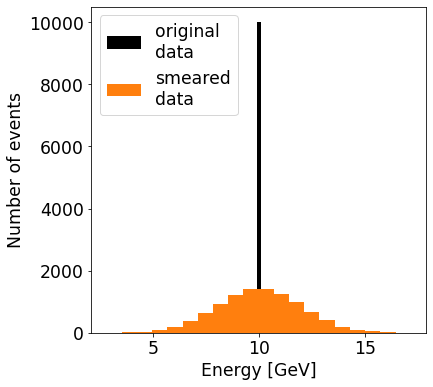

In [17]:
data = np.full(shape=10000, fill_value=10)

sigma = 0.2
smeared_data = smearEnergy(data, sigma)

fig, ax = plt.subplots(figsize = (6, 6))  
ax.hist(data, bins=5, color="black",label = 'original\ndata')
ax.hist(smeared_data, bins=20, color="#ff7f0e", label = 'smeared\ndata');
ax.legend(loc="upper left")
ax.set_ylabel("Number of events");
ax.set_xlabel("Energy [GeV]");

delta = smeared_data/data -1
print("Relative standard deviation for the smeared data: {:3.2f}".format(np.std(delta)))

## Homework

Write a generator for electron - positron pairs from the Z boson decay. Assume the Z boson is at rest. Since the pairs originate from the Z boson decay the pair invariant mass corresponds to the Breit-Wigner (BW) distribution for the Z boson. Take $m_{Z} = 92.1876$, $\Gamma = 2.4952$ for the BW distribution.

* generate events with the pair energy in range [50,200]
* assume the decay is isotropic (is this fully correct?)
* generate at least 500k events. How long it takes? What is the generation effciency?
* plot histogram of the pair invariant mass with linear and log Y scales. Overlay with probability distribution for invariant mass
* plot histogram of electrons momentum $cos(\theta)$
* plot histogram of transverse electron momentum $p_{T}$. Overlay with probability distribution for transverse momentum.

**Hint:** the probability distibution for the $p_{T}$ can be obtained from the chain rule:

\begin{equation}
\frac{d\sigma}{dp_{T}} =  \frac{d\sigma}{d\cos(\theta)} \frac{d\cos(\theta)}{dp_{T}}
\end{equation}

Use the nominal Z boson massuse the nominal Z boson mass while calculating the $\frac{d\sigma}{dp_{T}}$.

In [18]:
minS = 50
maxS = 200

m_Z = 92.1876
gamma_Z = 2.4952

def BreitWigner(s, m, gamma):
    numerator = gamma**2
    denominator = (s-m)**2 + gamma**2
    norm = 1.0/(math.pi*gamma)
    return norm*numerator/denominator

def generateCandidateEnergy(nPoints):
    s = (maxS-minS)*np.random.random(nPoints) + minS
    bw_values = BreitWigner(s, m_Z, gamma_Z)/BreitWigner(m_Z, m_Z, gamma_Z)
    accepted = np.random.random(s.shape[0])<bw_values
    return s[accepted]/2.0

def generateCandidateMomenta(energy):
    m_e = scipy_constants.physical_constants["electron mass energy equivalent in MeV"][0]
    momentum = np.sqrt(energy*energy - m_e*m_e)
    angles = np.random.random((energy.shape[0],2))
    scale = [2, 2*math.pi]
    offset = [-1, 0]
    angles = angles*scale + offset
    cosTheta = angles[:,0]
    sinTheta = np.sqrt(1 - cosTheta**2)
    px = momentum*sinTheta*np.cos(angles[:,1])
    py = momentum*sinTheta*np.sin(angles[:,1])
    pz = momentum*cosTheta
    
    p4_electron = np.column_stack([energy, px,py,pz])
    p4_positron = np.column_stack([energy, -px,-py,-pz])
    return  p4_electron, p4_positron

def generateEvents(nPoints):
    energy = generateCandidateEnergy(nPoints)
    data = generateCandidateMomenta(energy)
    return data

def invMass(p4):
    metric = np.array([1,-1,-1,-1])
    p4_square = p4*(metric*p4)
    m = np.sqrt(np.sum(p4_square, axis=1))
    return m

Generated 50874 events for 1000000 tries. 
Efficiency: 0.05
CPU times: user 207 ms, sys: 0 ns, total: 207 ms
Wall time: 203 ms


<timed exec>:29: RuntimeWarning: invalid value encountered in sqrt


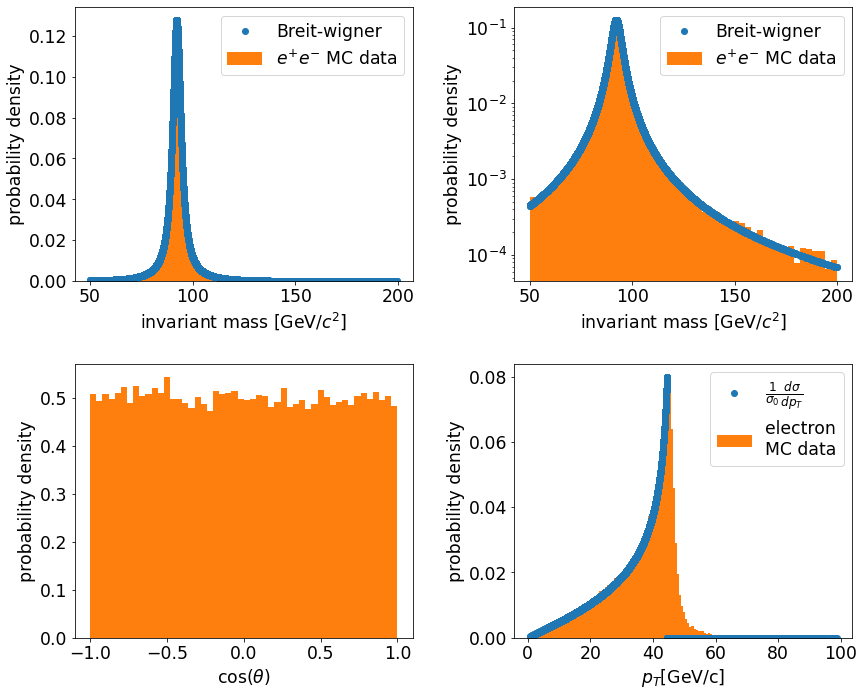

In [19]:
%%time

nPoints = 1000000
p4_electron, p4_positron = generateEvents(nPoints)
m = invMass(p4_electron + p4_positron)
print("Generated {} events for {} tries. \nEfficiency: {:3.2f}".format(m.shape[0], nPoints, float(m.shape[0])/nPoints))

fig, axes = plt.subplots(2,2, figsize=(12, 12))
axes[0,0].plot(m, BreitWigner(m, m_Z, gamma_Z), "o",label="Breit-wigner");
axes[0,0].hist(m, bins=50, density=True, color="#ff7f0e", label=r"$e^{+}e^{-}$ MC data");
axes[0,0].set_xlabel(r"invariant mass [GeV/$c^{2}$]")
axes[0,0].set_ylabel("probability density")
axes[0,0].legend(loc="upper right");

axes[0,1].plot(m, BreitWigner(m, m_Z, gamma_Z), "o",label="Breit-wigner");
axes[0,1].hist(m, bins=50, density=True, color="#ff7f0e", label=r"$e^{+}e^{-}$ MC data");
axes[0,1].set_xlabel(r"invariant mass [GeV/$c^{2}$]")
axes[0,1].set_ylabel("probability density")
axes[0,1].set_yscale("log", nonpositive='clip')
axes[0,1].legend(loc="upper right");

pT = np.sqrt(np.sum(p4_electron[:,1:3]*p4_electron[:,1:3], axis=1))
pL = p4_electron[:,3]
p = np.sqrt(pT**2 + pL**2)

cosTheta = pL/p
axes[1,0].hist(cosTheta, bins=50, density=True, color="#ff7f0e", label="electrons");
axes[1,0].set_xlabel(r"$\cos(\theta)$")
axes[1,0].set_ylabel("probability density")

pT_dist = pT/(m_Z/2)**2/np.sqrt(1 - (pT/(m_Z/2))**2)
pT_dist = np.where(pT_dist<0.08, pT_dist, 0)
axes[1,1].plot(pT, pT_dist,"o" ,label=r"$\frac{1}{\sigma_{0}}\frac{d\sigma}{dp_{T}}$");
axes[1,1].hist(pT, bins=150, density=True, color="#ff7f0e", label="electron\nMC data");
axes[1,1].set_xlabel(r"$p_{T}$[GeV/c]")
axes[1,1].set_ylabel("probability density")
axes[1,1].legend(loc="upper right");

plt.subplots_adjust(bottom=0.15, left=0.05, right=0.95, wspace=0.3, hspace=0.3)